In [1]:
import pandas as pd
from bs4 import BeautifulSoup as bs
import requests
from selenium.webdriver import Firefox
from selenium.common.exceptions import TimeoutException
import time
import matplotlib.pyplot as plt
from datetime import date

In [2]:
bets = pd.read_csv('my_preds.csv')
prevs = pd.read_csv('bet_history.csv')
players_name_df = pd.read_csv('Player_URL_Stats_Real.csv')

In [3]:
bets

,Name,Bet,preds,my_Bet
0,Domantas Sabonis,39.5,38.270270,1.833333
1,Giannis Antetokounmpo,52.5,50.066667,1.833333
2,Pascal Siakam,37.5,40.500000,1.833333


# of bets win: 120
% of bets win: 53.333333333333336


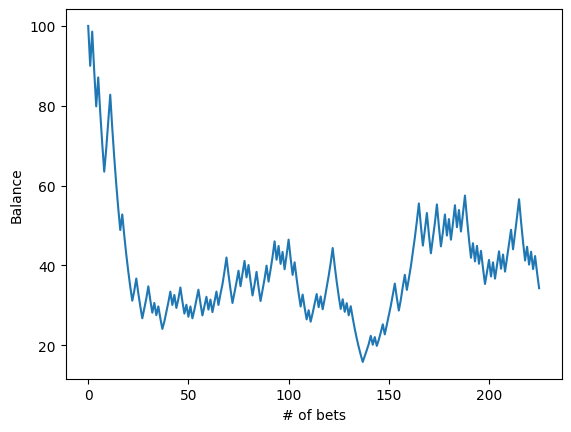

In [29]:
plt.xlabel('# of bets')
plt.ylabel('Balance')
plt.plot(prevs['History'])
print(f'# of bets win: {int(prevs["Wins"].tail(1))}')
print(f'% of bets win: {(int(prevs["Wins"].tail(1))/(prevs.shape[0]-1))*100}')

In [30]:
names = list(bets['Name'])

In [31]:
url = 'https://www.basketball-reference.com/boxscores/'
req = requests.get(url)
soup = bs(req.content, 'lxml')

In [32]:
games = soup.find_all('div', {'class': 'game_summary expanded nohover'})

In [33]:
links = []
for game in games:
    link = game.find('td', {'class': 'right gamelink'}) \
               .find('a').get('href')
    links.append(link)

In [34]:
print(f'# of games: {len(links)}\nGames:')
links

# of games: 5
Games:


['/boxscores/202302140LAC.html',
 '/boxscores/202302140MIL.html',
 '/boxscores/202302140PHO.html',
 '/boxscores/202302140POR.html',
 '/boxscores/202302140TOR.html']

In [35]:
driver = Firefox()
games = []
for idx, link in enumerate(links):
    url = f'https://www.basketball-reference.com{link}'
    
    time.sleep(idx)
    
    html = None
    for i in range(3):
        try:
            driver.get(url)

            html = driver.page_source
            soup = bs(html, 'lxml')
            
        except TimeoutException:
            print(f'{i}: TimeoutError on {url}')
            continue
        else:
            break

    if html:
        game = []
        main_table = soup.find('table', {'id': 'line_score'}) \
                         .find('tbody')
        rows = main_table.find_all('th', {'scope': 'row', 
                                          'data-stat': 'team'})
        for row in rows:
            team = row.find('a').text
            game.append(team)
            
        games.append(game)
        
games

[['GSW', 'LAC'],
 ['BOS', 'MIL'],
 ['SAC', 'PHO'],
 ['WAS', 'POR'],
 ['ORL', 'TOR']]

In [36]:
stats = []
for idx, link in enumerate(links):
    url = f'https://www.basketball-reference.com{link}'
    
    time.sleep(idx)
    
    html = None
    for i in range(3):
        try:
            driver.get(url)

            html = driver.page_source
            soup = bs(html, 'lxml')
            
        except TimeoutException:
            print(f'\n{i}: TimeoutError on {url}\n')
            continue
        else:
            break

    if html:
        for team in games[idx]:
            table = soup.find('table', 
                              {'id': f'box-{team}-game-basic'}) \
                        .find('tbody')
            rows = table.find_all('tr')
            
            for row in rows:
                name = row.find('th').find('a')
                
                if (name) and (name.text in names):
                    cond = row.find('td', {'data-stat': 'reason'})
                    if not cond:
                        print(name.text)

                        pts = int(row.find('td', {'data-stat': 'pts'}).text)
                        trb = int(row.find('td', {'data-stat': 'trb'}).text)
                        ast = int(row.find('td', {'data-stat': 'ast'}).text)

                        total = pts + trb + ast
                        player = {'Name': name.text, 'Total': total}

                        stats.append(player)
driver.close()

Giannis Antetokounmpo
Domantas Sabonis
Pascal Siakam


In [37]:
print(f'Players Found: {(len(stats)/len(names))*100}')

Players Found: 100.0


In [38]:
stats = pd.DataFrame(stats)
merged = pd.merge(bets, stats)
merged

,Name,Bet,preds,my_Bet,Total
0,Domantas Sabonis,39.5,38.270270,1.833333,46
1,Giannis Antetokounmpo,52.5,50.066667,1.833333,58
2,Pascal Siakam,37.5,40.500000,1.833333,36


In [39]:
balance = 100
history = [balance]
win, wins = 0, [0]
for i in range(merged.shape[0]):
    row = merged.iloc[i]
    
    line = row['Bet']
    my_pred = row['preds']
    my_bet = row['my_Bet']
    total = row['Total']
    
    bet = balance * 0.1
    balance -= bet    
    if (line < my_pred) and (line < total):
        income = bet * my_bet
        balance += income
        win += 1
        wins.append(win)
    elif (line > my_pred) and (line > total):
        income = bet * my_bet
        balance += income
        win += 1
        wins.append(win)
    else:
        wins.append(win)
    
    history.append(balance)

# of bets win: 0
% of bets win: 0.0
Final Balance: 72.9


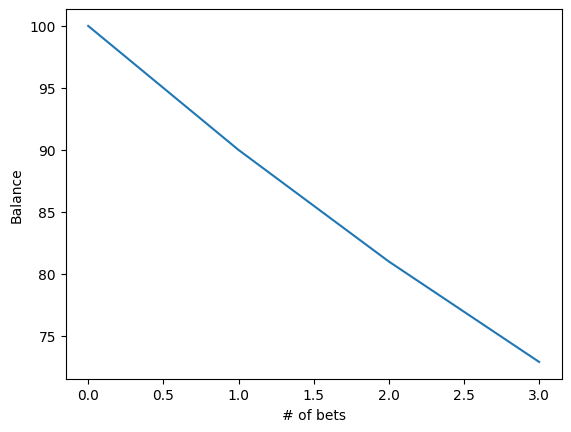

In [40]:
plt.xlabel('# of bets')
plt.ylabel('Balance')
plt.plot(history)
print(f'# of bets win: {wins[-1]}')
print(f'% of bets win: {(wins[-1]/len(wins))*100}')
print(f'Final Balance: {history[-1]}')

In [41]:
del prevs['Unnamed: 0']

In [42]:
balance = float(prevs['History'].tail(1))
history = list(prevs['History'])
wins = list(prevs['Wins'])
win = wins[-1] 
for i in range(merged.shape[0]):
    row = merged.iloc[i]
    
    line = row['Bet']
    my_pred = row['preds']
    my_bet = row['my_Bet']
    total = row['Total']
    
    bet = balance * 0.1
    balance -= bet    
    if (line < my_pred) and (line < total):
        income = bet * my_bet
        balance += income
        win += 1
        wins.append(win)
    elif (line > my_pred) and (line > total):
        income = bet * my_bet
        balance += income
        win += 1
        wins.append(win)
    else:
        wins.append(win)
    
    history.append(balance)

# of bets win: 120
% of bets win: 52.40174672489083
Final balance: 25.00626449312007


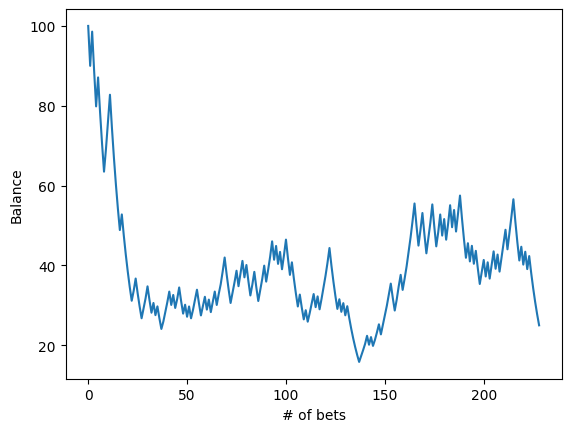

In [43]:
plt.xlabel('# of bets')
plt.ylabel('Balance')
plt.plot(history)
print(f'# of bets win: {wins[-1]}')
print(f'% of bets win: {(wins[-1]/len(wins))*100}')
print(f'Final balance: {history[-1]}')

In [44]:
list(prevs['Wins'])[-1]

120

In [45]:
prev_idx = prevs.shape[0]
prevs

,Date,History,Wins
0,2022-12-23,100.000000,0
1,2022-12-23,90.000000,0
2,2022-12-23,98.571429,1
3,2022-12-23,88.714286,1
4,2022-12-23,79.842857,1
...,...,...,...
221,2023-02-14,43.434183,119
222,2023-02-14,39.090765,119
223,2023-02-14,42.348328,120
224,2023-02-14,38.113496,120


In [46]:
history[prev_idx:]

[30.871931472987747, 27.78473832568897, 25.00626449312007]

In [47]:
results = {'Date': date.today(), 'History': history[prev_idx:], 
           'Wins': wins[prev_idx:]}
results = pd.DataFrame(results)

In [48]:
results = pd.concat([prevs,results])
results

,Date,History,Wins
0,2022-12-23,100.000000,0
1,2022-12-23,90.000000,0
2,2022-12-23,98.571429,1
3,2022-12-23,88.714286,1
4,2022-12-23,79.842857,1
...,...,...,...
224,2023-02-14,38.113496,120
225,2023-02-14,34.302146,120
0,2023-02-15,30.871931,120
1,2023-02-15,27.784738,120


In [49]:
results.to_csv('bet_history.csv')